## Control Problem with Neural ODE with Energy Functional

In [18]:
%reset -f

In [19]:
import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.numpy as jnp
import optax  # https://github.com/deepmind/optax

import time
from utils import *;

For some reason, GPU is really slow on this task, so let's use CPU

In [20]:
jax.config.update('jax_platform_name', 'cpu')
print(jax.numpy.ones(3).device()) # should be TFRT_CPU_0

TFRT_CPU_0


We are solving the optimal control problem:
\begin{align}
    u^*(t) = \argmin_{u(t)}{J(u)}
\end{align}
- with $J(u) = \int_0^T (u(t))^2 \, \text{d}t + \frac{1}{2}\left( y(T/2) - y_1 \right)^2 + \frac{1}{2}\left( y(T) - y_2 \right)^2$
- subject to the ODE $y'(t) = u(t)$
- terminal states $y(0) = y_0$, $y(T/2) \approx y_1$, and $y(T) \approx y_2$

We want to lean a near-optimal control $\hat u$ by parametrising it via a MLP; or even better, an even simpler linear layer. We will then be able to define the control problem using the Neural ODE formulation.

In [73]:
class Func(eqx.Module):
    mlp: eqx.nn.MLP

    def __init__(self, data_size, width_size, depth, *args, key, **kwargs):
        super().__init__(**kwargs)
        self.mlp = eqx.nn.MLP(
            in_size=data_size+1,        ## Input is t and y0
            out_size=data_size,         ## Output is yT
            width_size=width_size,
            depth=depth,
            activation=jax.nn.relu,
            # activation=jax.nn.softplus,
            # activation=lambda x:x,      ## No activation at all
            key=key,
        )

    def __call__(self, t, y, *args):
        input_vec = jnp.array([t, args[0][0]])  ## args[0] is the y0 PyTree (of size 1) - input_vec must be a 1D array to avoid broadcasting
        return self.mlp(input_vec)


class NeuralODE(eqx.Module):
    u: Func

    def __init__(self, data_size, width_size, depth, *args, key, **kwargs):
        super().__init__(**kwargs)
        self.u = Func(data_size, width_size, depth, key=key)

    def __call__(self, ts, y0):
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.u),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1]-ts[0],
            y0=y0,
            args=y0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=diffrax.SaveAt(ts=ts),
        )
        return solution.ys

In [94]:
T = 1.0
N = 200

data_size = 1
width_size = 2
depth = 1
seed = int(time.time())
# seed = 3440
key = jax.random.PRNGKey(seed)

model = NeuralODE(data_size, width_size, depth, key=key)
print("Behold the control term: \n----------------------- \n", model.u)

ts = jnp.linspace(0, T, N)
y0 = jnp.array([1.0])
print("\nTesting the control term: \n----------------------- \n", model.u(ts[0], y0, y0))

Behold the control term: 
----------------------- 
 Func(
  mlp=MLP(
    layers=[
      Linear(
        weight=f32[2,2],
        bias=f32[2],
        in_features=2,
        out_features=2,
        use_bias=True
      ),
      Linear(
        weight=f32[1,2],
        bias=f32[1],
        in_features=2,
        out_features=1,
        use_bias=True
      )
    ],
    activation=<wrapped function relu>,
    final_activation=<function _identity>,
    in_size=2,
    out_size=1,
    width_size=2,
    depth=1
  )
)

Testing the control term: 
----------------------- 
 [-0.63178253]


Given the target state $y^*$, we can randomly construct training data.

In [95]:
y1 = -1.0 ## target states
y2 = 1.0

def _get_data(ts, *args, key):
    y0 = jax.random.uniform(key, (1,), minval=-2.0, maxval=4.0)
    ytarget = jnp.array([[y1], [y2]])
    return jnp.vstack((y0, ytarget))

def get_data(dataset_size, *args, key):
    ts = jnp.linspace(0, T, N)
    key = jax.random.split(key, dataset_size)
    ys = jax.vmap(lambda key: _get_data(ts, key=key))(key)
    return ts, ys

def dataloader(array, batch_size, *args, key):
    dataset_size = array.shape[0]
    indices = jnp.arange(dataset_size)
    perm = jax.random.permutation(key, indices)
    start = 0
    end = batch_size
    while end < dataset_size:
        batch_perm = perm[start:end]
        yield array[batch_perm]
        start = end
        end = start + batch_size

In [96]:
dataset_size = 256
batch_size = 32
data_key, loader_key = jax.random.split(key, 2)

_, ys = get_data(dataset_size, key=data_key)
train_loader = dataloader(ys, batch_size, key=loader_key)

In [97]:
lr = 3e-3
optim = optax.adabelief(lr)
opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))

@eqx.filter_value_and_grad
def grad_loss(model, ti, yi):
    ypred = jax.vmap(model, in_axes=(None, 0))(ti, yi[:, 0])
    target_pos = jnp.array([N//2, N-1])
    fatefulness = jnp.sum(0.5 * (yi[:, 1:] - ypred[:, target_pos]) ** 2, axis=1)

    mapped1 = jax.vmap(model.u, in_axes=(0, None, None), out_axes=0)
    mapped2 = jax.vmap(mapped1, in_axes=(1, None, 0), out_axes=0)
    ut = mapped2(jnp.tile(ts[:, jnp.newaxis], yi.shape[0]), ypred, ypred[:, 0])[:,:,0]
    dts = ti[1:] - ti[:-1]
    energy = jnp.sum(dts*(ut[:, :-1]**2), axis=1)

    return jnp.mean(fatefulness + 0.001*energy)

@eqx.filter_jit
def make_step(ti, yi, model, opt_state):
    loss, grads = grad_loss(model, ti, yi)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

Step: 100, Loss: 3.0821454524993896, Computation time: 0.010054349899291992
Step: 200, Loss: 2.1563587188720703, Computation time: 0.016659975051879883
Step: 300, Loss: 1.9241267442703247, Computation time: 0.009229183197021484
Step: 400, Loss: 1.321148157119751, Computation time: 0.011624813079833984
Step: 500, Loss: 0.9028894901275635, Computation time: 0.018559694290161133
Step: 600, Loss: 0.6802021861076355, Computation time: 0.02109074592590332
Step: 700, Loss: 0.5744795799255371, Computation time: 0.014330148696899414
Step: 800, Loss: 0.4318612813949585, Computation time: 0.04014110565185547
Step: 900, Loss: 0.29038742184638977, Computation time: 0.019252777099609375
Step: 1000, Loss: 0.25932395458221436, Computation time: 0.019104957580566406
Step: 1100, Loss: 0.17576220631599426, Computation time: 0.015828609466552734
Step: 1200, Loss: 0.1250735968351364, Computation time: 0.019484996795654297
Step: 1300, Loss: 0.10091518610715866, Computation time: 0.0163114070892334
Step: 140

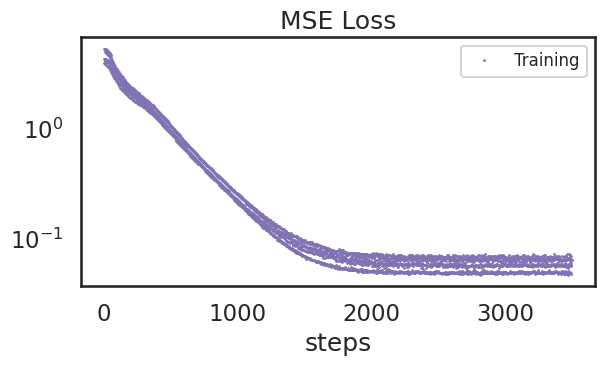

In [98]:
epochs = 500

step = 0
losses = []
for epoch in range(epochs):
    for yi in dataloader(ys, batch_size, key=loader_key):
        start = time.time()
        loss, model, opt_state = make_step(ts, yi, model, opt_state)
        end = time.time()
        step += 1
        losses.append(loss)
        if (step % 100) == 0:
            print(f"Step: {step}, Loss: {loss}, Computation time: {end - start}")

fig, ax = plt.subplots(1,1,figsize=(6,4))
plot(losses, "m.", label="Training", x_label="steps", title="MSE Loss", markersize=2, ax=ax)
ax.set_yscale('log')

Let's plot the results.

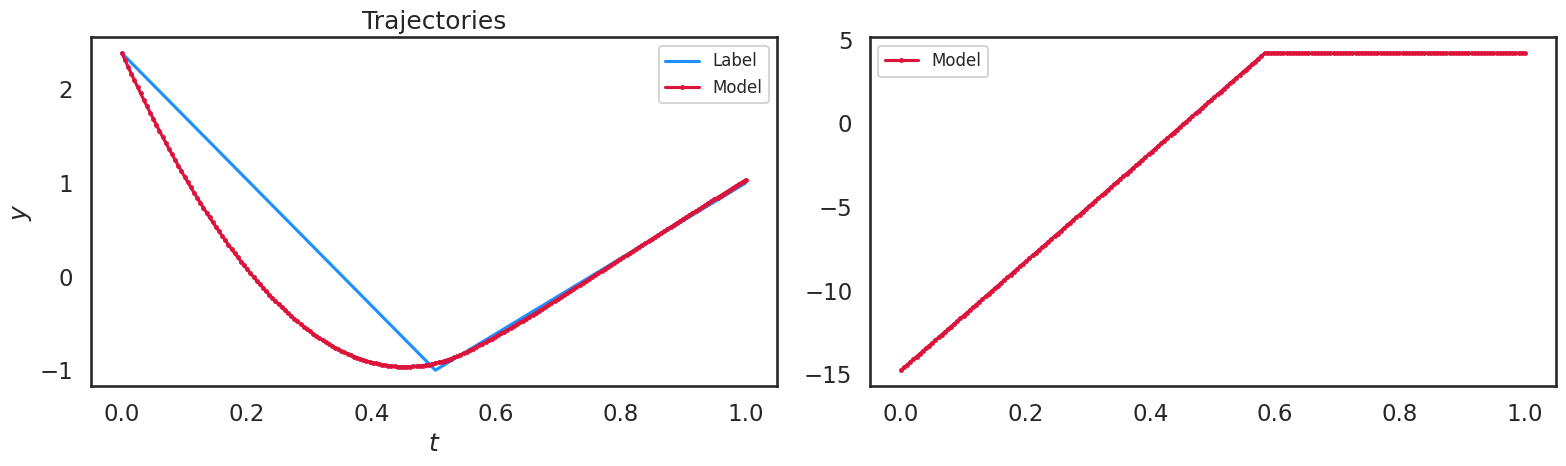

In [113]:
test_gen_key = jax.random.PRNGKey(int(time.time()))

ytrue = _get_data(ts, key=test_gen_key)
ypred = model(ts, ytrue[0])[:]
# utrue = jnp.ones_like(ytrue) * (y2-ytrue[0])/T
upred = jax.vmap(model.u, in_axes=(0, None, None))(ts, ypred, ypred[0])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8*2, 5))
tplot = [ts[0], ts[N//2], ts[-1]]
ax1 = plot(tplot, ytrue, c="dodgerblue", label="Label", title="Trajectories", x_label=r"$t$", y_label=r"$y$", ax=ax1)
ax1 = plot(ts, ypred, ".-", c="crimson", label="Model", markersize=5, ax=ax1)

# ax2 = plot(tplot, utrue, c="dodgerblue", label="Optimal", ax=ax2)
ax2 = plot(ts, upred, ".-", c="crimson", label="Model", title="Controls", x_label=r"$t$", y_label=r"$u$", markersize=5, ax=ax2)
# ax2.set_ylim(-5, 5);

## Findings
- Inclusing the middle position as a constraint works if we increase the size of the MLP, and use ReLU
- I still don't understand the up-and-down dots for the loss !!

## Questions
- Can we analytically recover the optimal control, as the network doestn't seem to know the shortest path ?
- Is the shortest path also the optimal trajectory and/or the MIN (corresponding to the defined cost criteria) ?
- Could we use SINDy to recover the governing equation for the controls ?

## Next steps
- Redo these examples with stochatic control
- Uncertainty quantify the trajectories, especially when initial state is known
- Generate trajectories based on probability density estimation: Bayessian Neural Network or CNF ?